In [1]:
import numpy as np
import matplotlib.pyplot as plt

import mne

from GigascienceDataset import SubjectData

In [2]:
sd = SubjectData('data/s09.mat')

Creating RawArray with float64 data, n_channels=69, n_times=430080
    Range : 0 ... 430079 =      0.000 ...   839.998 secs
Ready.
Creating RawArray with float64 data, n_channels=69, n_times=430080
    Range : 0 ... 430079 =      0.000 ...   839.998 secs
Ready.
Creating RawArray with float64 data, n_channels=69, n_times=71680
    Range : 0 ... 71679 =      0.000 ...   139.998 secs
Ready.
Creating RawArray with float64 data, n_channels=69, n_times=71680
    Range : 0 ... 71679 =      0.000 ...   139.998 secs
Ready.
Creating RawArray with float64 data, n_channels=68, n_times=33920
    Range : 0 ... 33919 =      0.000 ...    66.248 secs
Ready.
Creating RawArray with float64 data, n_channels=68, n_times=5120
    Range : 0 ... 5119 =      0.000 ...     9.998 secs
Ready.
Creating RawArray with float64 data, n_channels=68, n_times=5120
    Range : 0 ... 5119 =      0.000 ...     9.998 secs
Ready.
Creating RawArray with float64 data, n_channels=68, n_times=5120
    Range : 0 ... 5119 =      0.

## Pipeline design
+ Get ICA components from the entire data (for each mat)
+ Generate features for each movement and imagery epoch using ICA
+ Extract features using CSP
+ Exp1: training on movement (left & right) and predicing on movement (left & right)
+ Exp2: training on imagery (left & right) and predicing on imagery (left & right)
+ Exp3: training on movement (left & right) and predicing on imagery (left & right)

In [3]:
mat_all = np.hstack(
    list(sd.mat_noise) + [
        sd.mat_rest, 
        sd.mat_movement_left, 
        sd.mat_movement_right, 
        sd.mat_imagery_left, 
        sd.mat_imagery_right])
raw_all = mne.io.RawArray(mat_all, sd.raw_rest.info)
raw_all.set_montage(sd.raw_rest.get_montage())

Creating RawArray with float64 data, n_channels=68, n_times=1063040
    Range : 0 ... 1063039 =      0.000 ...  2076.248 secs
Ready.


<RawArray | 68 x 1063040 (2076.2 s), ~551.7 MB, data loaded>

Effective window size : 4.000 (s)


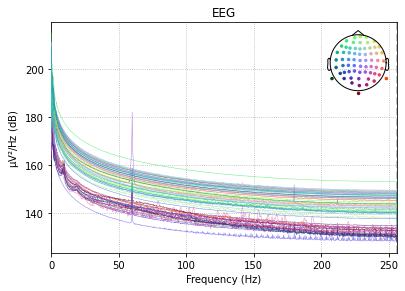

In [20]:
raw_all.plot_psd()
plt.show()

In [4]:
ica = mne.preprocessing.ICA(n_components=64, random_state=97, max_iter=800)
ica.fit(raw_all)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 64 components
Fitting ICA took 539.6s.


<ICA | raw data decomposition, fit (fastica): 1063040 samples, 64 components, channels used: "eeg">

In [48]:
period = 3584

def get_segments(raw, label):
    events = mne.find_events(raw)[:,0]
    mat = ica.get_sources(raw)
    data = np.dstack([
        mat[:,event * period: (event + 1) * period][0]
        for event in range(mat.get_data().shape[1] // period)
    ]).transpose((2, 0, 1))
    labels = np.zeros(events.shape) + label
    return data, labels

In [54]:
data, labels = zip(*[
    get_segments(raw, label)
    for label, raw in enumerate([
        sd.raw_movement_left,
        sd.raw_movement_right,
        sd.raw_imagery_left,
        sd.raw_imagery_right
    ])
])
data = np.vstack(data)
labels = np.hstack(labels)
data.shape

20 events found
Event IDs: [1]
20 events found
Event IDs: [1]
120 events found
Event IDs: [1]
120 events found
Event IDs: [1]


(280, 64, 3584)

In [67]:
X_move = data[:40,:,:]
X_ima = data[40:,:,:]
Y_move = labels[:40] % 2
Y_ima = labels[40:] % 2

Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 64 dim * 7.8e+14  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 64 dim * 7.9e+14  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


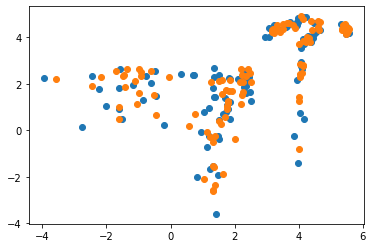

In [72]:
# train on move, test on ima

model = mne.decoding.CSP(n_components=2)
model.fit(X_move, Y_move)
X_ima_trans = model.transform(X_ima)
for label in 0, 1:
    filter = Y_ima == label
    plt.scatter(X_ima_trans[filter,0], X_ima_trans[filter,1])

In [89]:
from sklearn.model_selection import train_test_split
# train on move, test on move
X_move_train, X_move_test, Y_move_train, Y_move_test = train_test_split(X_move, Y_move, random_state=13)
# train on ima, test on ima
X_ima_train, X_ima_test, Y_ima_train, Y_ima_test = train_test_split(X_ima, Y_ima, random_state=13)

Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 64 dim * 7.1e+14  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 64 dim * 7.8e+14  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


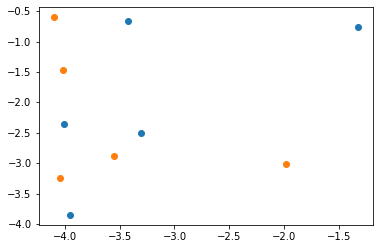

In [90]:
# train on move, test on move

model = mne.decoding.CSP(n_components=2)
model.fit(X_move_train, Y_move_train)
X_move_trans = model.transform(X_move_test)
for label in 0, 1:
    filter = Y_move_test == label
    plt.scatter(X_move_trans[filter,0], X_move_trans[filter,1])

Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 64 dim * 8.6e+14  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 64 dim * 8.2e+14  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


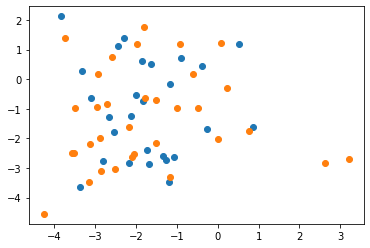

In [94]:
# train on ima, test on ima

model = mne.decoding.CSP(n_components=2)
model.fit(X_ima_train, Y_ima_train)
X_ima_trans = model.transform(X_ima_test)
for label in 0, 1:
    filter = Y_ima_test == label
    plt.scatter(X_ima_trans[filter,0], X_ima_trans[filter,1])

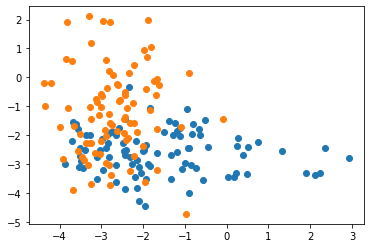

In [92]:
X_ima_trans = model.transform(X_ima_train)
for label in 0, 1:
    filter = Y_ima_train == label
    plt.scatter(X_ima_trans[filter,0], X_ima_trans[filter,1])